<h3> RA response PRS prediction project </h3>

In [1]:
import numpy as np
import pandas as pd
import magenpy as mgp
import scipy.stats as chi2
from sklearn.decomposition import PCA
# from pandas_genomics.scalars import Genotype


Read the chr22.gen file and conever to .bed file

In [3]:
chr22_geno_path = "data/DREAM_RA_Responders_GenProbData/Training_chr22.gen"
df = pd.read_csv(chr22_geno_path, sep=' ', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,8114,8115,8116,8117,8118,8119,8120,8121,8122,8123
0,22,rs915674,16053624,A,G,0.02,0.23,0.75,0.02,0.23,...,0.02,0.23,0.75,0.02,0.23,0.75,0.02,0.23,0.75,NaN
1,22,rs915677,16053758,A,G,0.00,0.13,0.87,0.00,0.13,...,0.00,0.13,0.87,0.00,0.13,0.87,0.00,0.13,0.87,NaN
2,22,rs9604721,16054713,C,T,0.93,0.07,0.00,0.93,0.07,...,0.93,0.07,0.00,0.93,0.07,0.00,0.93,0.07,0.00,NaN
3,22,rs4389403,16055070,A,G,0.01,0.19,0.79,0.01,0.19,...,0.01,0.19,0.79,0.01,0.19,0.79,0.01,0.19,0.79,NaN
4,22,rs9617528,16061016,C,T,0.07,0.38,0.55,0.07,0.38,...,0.07,0.38,0.55,0.07,0.38,0.55,0.07,0.38,0.55,NaN


In [4]:
# get the patient ID from the full clinical data.
clinical_full = pd.read_csv("data/DREAM_RA_Responders_PhenoCov_Full.txt", sep=' ', header=None)
full_ID = np.array(clinical_full[0].shift(-1))[:-1]
print("number of patients: ", len(full_ID))
full_ID
clinical_full             

number of patients:  2706


,0,1,2,3,4,5,6,7,8,9,10
0,ID,Response.deltaDAS,Response.NonResp,Response.EULAR,Batch,Cohort,Drug,baselineDAS,Age,Gender,Mtx
1,1877000,-2.88,1,Supernon,dream1,DREAM,infliximab,3.18,54.02,0,1
2,612000,-2.44,1,Supernon,REF,new,infliximab,4.65,61.08333,1,1
3,111000,-2.17,1,Supernon,REF,EIRA,etanercept,4.38,58,1,1
4,1780000,-2.11,1,Non,dream1,DREAM,infliximab,2.45,51.07,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2702,2732000,2.76,0,Good,dream3,DREAM,adalimumab,5.19,NaN,1,1
2703,2736000,3.13,0,Intermediate,dream3,DREAM,adalimumab,6.59,NaN,1,1
2704,2744000,3.32,0,Intermediate,dream3,DREAM,adalimumab,6.74,NaN,1,1
2705,2748000,1.59,0,Intermediate,dream3,DREAM,adalimumab,5.01,NaN,1,1


In [5]:
# attempt to generate .sample file
col = [0, 1, 9]
sample = clinical_full.iloc[1:, col]
header = pd.MultiIndex.from_tuples([('ID', '0'), ('Response.deltaDAS', 'P'), ('Sex', 'D')])
sample.columns = header



path = "data/DREAM_RA_Responders_PhenoCov_Full.sample"
sample.to_csv(path, sep=' ', index=False)
sample

,ID,Response.deltaDAS,Sex
,0,P,D
1,1877000,-2.88,0
2,612000,-2.44,1
3,111000,-2.17,1
4,1780000,-2.11,1
5,825000,-1.97,1
...,...,...,...
2702,2732000,2.76,1
2703,2736000,3.13,1
2704,2744000,3.32,1


In [6]:
test = pd.read_csv("data/DREAM_RA_Responders_PhenoCov_Full.sample", sep=' ', header=[0, 1])
test

,ID,Response.deltaDAS,Sex
,0,P,D
0,1877000,-2.88,0.0
1,612000,-2.44,1.0
2,111000,-2.17,1.0
3,1780000,-2.11,1.0
4,825000,-1.97,1.0
...,...,...,...
2701,2732000,2.76,1.0
2702,2736000,3.13,1.0
2703,2744000,3.32,1.0


In [7]:
def gen_to_bed(gen_file, bed_file):
    # Read the .gen file into a pandas DataFrame
    df = pd.read_csv(gen_file, sep=' ', header=None)

    # Extract the relevant columns (e.g., chromosome, start position, end position)
    # and create a new DataFrame with the desired column names
    bed_df = pd.DataFrame()
    bed_df['chromosome'] = df[0]
    bed_df['SNP'] = df[1]
    
    for i in range(0,2706):   # patient ids from 0-2705
        pid = full_ID[i]
        bed_df[pid] =df.iloc[:, i*3+5].astype(str) + ', ' + df.iloc[:, i*3+6].astype(str) + ', ' + df.iloc[:, i*3+7].astype(str)

    # loop to fill in the genotype probabilities for the 2706 individuals 
    bed_df.to_csv(bed_file, sep=' ', index=False, header=False)


In [8]:
chr22_bed_try = "LD_chr22_training/chr22_try.bed"
gen_to_bed(chr22_geno_path, chr22_bed_try)

KeyboardInterrupt: 

In [20]:
input = pd.read_csv(chr22_bed_try, sep=' ', header=None)
input 

,0,1,2,3,4,5,6,7,8,9,...,2698,2699,2700,2701,2702,2703,2704,2705,2706,2707
0,22,rs915674,"0.02, 0.23, 0.75","0.02, 0.23, 0.75","0.02, 0.23, 0.75","0.02, 0.23, 0.75","0.02, 0.23, 0.75","0.02, 0.23, 0.75","0.02, 0.23, 0.75","0.02, 0.23, 0.75",...,"0.02, 0.23, 0.75","0.02, 0.23, 0.75","0.02, 0.23, 0.75","0.02, 0.23, 0.75","0.02, 0.23, 0.75","0.02, 0.23, 0.75","0.02, 0.23, 0.75","0.02, 0.23, 0.75","0.02, 0.23, 0.75","0.02, 0.23, 0.75"
1,22,rs915677,"0.0, 0.13, 0.87","0.0, 0.13, 0.87","0.0, 0.13, 0.87","0.0, 0.13, 0.87","0.0, 0.13, 0.87","0.0, 0.13, 0.87","0.0, 0.13, 0.87","0.0, 0.13, 0.87",...,"0.0, 0.13, 0.87","0.0, 0.13, 0.87","0.0, 0.13, 0.87","0.0, 0.13, 0.87","0.0, 0.13, 0.87","0.0, 0.13, 0.87","0.0, 0.13, 0.87","0.0, 0.13, 0.87","0.0, 0.13, 0.87","0.0, 0.13, 0.87"
2,22,rs9604721,"0.93, 0.07, 0.0","0.93, 0.07, 0.0","0.93, 0.07, 0.0","0.93, 0.07, 0.0","0.93, 0.07, 0.0","0.93, 0.07, 0.0","0.93, 0.07, 0.0","0.93, 0.07, 0.0",...,"0.93, 0.07, 0.0","0.93, 0.07, 0.0","0.93, 0.07, 0.0","0.93, 0.07, 0.0","0.93, 0.07, 0.0","0.93, 0.07, 0.0","0.93, 0.07, 0.0","0.93, 0.07, 0.0","0.93, 0.07, 0.0","0.93, 0.07, 0.0"
3,22,rs4389403,"0.01, 0.19, 0.79","0.01, 0.19, 0.79","0.01, 0.19, 0.79","0.01, 0.19, 0.79","0.01, 0.19, 0.79","0.01, 0.19, 0.79","0.01, 0.19, 0.79","0.01, 0.19, 0.79",...,"0.01, 0.19, 0.79","0.01, 0.19, 0.79","0.01, 0.19, 0.79","0.01, 0.19, 0.79","0.01, 0.19, 0.79","0.01, 0.19, 0.79","0.01, 0.19, 0.79","0.01, 0.19, 0.79","0.01, 0.19, 0.79","0.01, 0.19, 0.79"
4,22,rs9617528,"0.07, 0.38, 0.55","0.07, 0.38, 0.55","0.07, 0.38, 0.55","0.07, 0.38, 0.55","0.07, 0.38, 0.55","0.07, 0.38, 0.55","0.07, 0.38, 0.55","0.07, 0.38, 0.55",...,"0.07, 0.38, 0.55","0.07, 0.38, 0.55","0.07, 0.38, 0.55","0.07, 0.38, 0.55","0.07, 0.38, 0.55","0.07, 0.38, 0.55","0.07, 0.38, 0.55","0.07, 0.38, 0.55","0.07, 0.38, 0.55","0.07, 0.38, 0.55"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33740,22,rs2285395,"0.0, 0.0, 1.0","0.0, 0.0, 1.0","0.0, 0.0, 1.0","0.0, 0.0, 1.0","0.0, 0.0, 1.0","0.0, 0.13, 0.87","0.0, 0.12, 0.87","0.0, 0.17, 0.82",...,"0.0, 0.0, 1.0","0.0, 0.0, 1.0","0.0, 0.0, 1.0","0.0, 0.0, 1.0","0.0, 0.0, 1.0","0.0, 0.0, 1.0","0.0, 0.0, 1.0","0.0, 0.0, 1.0","0.0, 0.0, 1.0","0.0, 0.0, 1.0"
33741,22,rs8136603,"0.98, 0.02, 0.0","0.98, 0.02, 0.0","0.98, 0.02, 0.0","0.98, 0.02, 0.0","0.98, 0.02, 0.0","0.85, 0.15, 0.0","0.85, 0.14, 0.0","0.81, 0.18, 0.01",...,"0.97, 0.02, 0.0","0.98, 0.02, 0.0","0.98, 0.02, 0.0","0.98, 0.02, 0.0","0.98, 0.02, 0.0","0.98, 0.02, 0.0","0.98, 0.02, 0.0","0.98, 0.02, 0.0","0.98, 0.02, 0.0","0.99, 0.01, 0.0"
33742,22,rs3888396,"0.0, 0.19, 0.8","0.0, 0.27, 0.72","0.0, 0.2, 0.8","0.01, 0.44, 0.55","0.0, 0.08, 0.92","0.0, 0.16, 0.83","0.0, 0.17, 0.82","0.0, 0.16, 0.83",...,"0.0, 0.15, 0.85","0.0, 0.07, 0.92","0.0, 0.06, 0.94","0.0, 0.07, 0.93","0.0, 0.08, 0.92","0.01, 0.23, 0.76","0.0, 0.06, 0.94","0.0, 0.06, 0.94","0.0, 0.1, 0.89","0.0, 0.07, 0.93"
33743,22,rs2238837,"0.75, 0.23, 0.02","0.12, 0.68, 0.2","0.57, 0.36, 0.07","0.59, 0.37, 0.04","0.43, 0.5, 0.07","0.38, 0.47, 0.15","0.38, 0.47, 0.15","0.38, 0.47, 0.15",...,"0.57, 0.4, 0.03","0.15, 0.73, 0.12","0.14, 0.75, 0.11","0.08, 0.51, 0.4","0.24, 0.67, 0.09","0.28, 0.53, 0.19","0.14, 0.75, 0.11","0.14, 0.76, 0.11","0.15, 0.75, 0.11","0.14, 0.75, 0.12"


In [6]:
# example for utilizing mgp
g_sim = mgp.GWASimulator(mgp.tgp_eur_data_path(),
                         h2=0.1)
g_sim.simulate()
g_sim.to_phenotype_table()
#          FID      IID  phenotype
# 0    HG00096  HG00096   0.795651
# 1    HG00097  HG00097   0.550914
# 2    HG00099  HG00099  -0.928486
# 3    HG00100  HG00100   0.893626
# 4    HG00101  HG00101  -0.670106
# ..       ...      ...        ...
# 373  NA20815  NA20815   0.246071
# 374  NA20818  NA20818   1.821426
# 375  NA20819  NA20819  -0.457994
# 376  NA20826  NA20826   0.954208
# 377  NA20828  NA20828   0.088412
#
# [378 rows x 3 columns]


> Reading BED file...
> Generating polygenic scores...


,FID,IID,phenotype
0,HG00096,HG00096,0.425687
1,HG00097,HG00097,-0.918492
2,HG00099,HG00099,-0.226575
3,HG00100,HG00100,-1.241405
4,HG00101,HG00101,-0.789751
...,...,...,...
373,NA20815,NA20815,1.618050
374,NA20818,NA20818,-0.314308
375,NA20819,NA20819,-0.640369
376,NA20826,NA20826,1.358444


In [7]:
print(mgp.tgp_eur_data_path())

/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/magenpy/data/1000G_eur_chr22


In [8]:
chr22_bim_try = "/home/mcb/users/yzhu439/RA_Project/LD_chr22_training/chr22_try.bim"
chr22_fam_try = "/home/mcb/users/yzhu439/RA_Project/LD_chr22_training/chr22_try.fam"

bed_df = pd.read_csv(chr22_bed_try, sep=' ', header=None)
bed_df.to_csv(chr22_bim_try, sep=' ', index=False, header=False)
bed_df.to_csv(chr22_fam_try, sep=' ', index=False, header=False)



In [21]:
out = "/home/mcb/users/yzhu439/RA_Project/LD_chr22_training/chr22_tryLD_out/"
chr22_try_path = "/home/mcb/users/yzhu439/RA_Project/LD_chr22_training"
gdl = mgp.GWADataLoader(chr22_try_path,backend='plink')
 
gdl.compute_ld(estimator='windowed',
               output_dir=out,
               window_size=3.)
# gdl.compute_ld(estimator='windowed', output_dir=out, window_size=100)

/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/magenpy/GWADataLoader.py:336: UserWarning: No BED files were found at: /home/mcb/users/yzhu439/RA_Project/LD_chr22_training
  warnings.warn(f"No BED files were found at: {bed_paths}")


TypeError: object of type 'NoneType' has no len()

<h3> Convert clinical data .txt to .sample </h3>

In [22]:
import os
def convert_txt_to_sample(file_path):
    # Read the content of the .txt file
    with open(file_path, 'r') as txt_file:
        content = txt_file.read()

    # Change the file extension to .sample
    out_path = "/home/mcb/users/yzhu439/RA_Project/sample_clinicalData/DREAM_RA_Responders_PhenoCov_Full"
    new_file_path = os.path.splitext(out_path)[0] + '.sample'

    # Write the content to the .sample file
    with open(new_file_path, 'w') as sample_file:
        sample_file.write(content)

    print(f"Conversion complete. File saved as {new_file_path}")
    
clinical_full_path = "data/DREAM_RA_Responders_PhenoCov_Full.txt"
convert_txt_to_sample(clinical_full_path)

Conversion complete. File saved as /home/mcb/users/yzhu439/RA_Project/sample_clinicalData/DREAM_RA_Responders_PhenoCov_Full.sample


<h3>Read the plink.assoc.linear</h3>


In [18]:
linear_data = pd.read_csv('plink.assoc.linear', sep='\s+')
linear_data #for merge10.bed, has a .nosex file 

,CHR,SNP,BP,A1,TEST,NMISS,BETA,STAT,P
0,0,200003,0,G,ADD,703,-0.05554,-0.7707,0.4411
1,0,200006,0,A,ADD,703,-0.02408,-0.3352,0.7376
2,0,200050,0,C,ADD,417,-0.07902,-0.1913,0.8484
3,0,200052,0,A,ADD,417,-0.07902,-0.1913,0.8484
4,0,200053,0,G,ADD,417,-0.07902,-0.1913,0.8484
...,...,...,...,...,...,...,...,...,...
1342721,26,MitoA16164,16164,G,ADD,574,0.40980,0.9125,0.3619
1342722,26,MitoC16184,16184,C,ADD,578,0.20460,0.7126,0.4764
1342723,26,MitoC16280,16280,A,ADD,169,-0.31720,-0.3048,0.7609
1342724,26,MitoG16392,16392,A,ADD,171,0.54980,0.6496,0.5168


In [47]:
# Using plink:
import magenpy as mgp
path = "data/Merged_Genotype/merged1"
gdl = mgp.GWADataLoader(path)
gdl.compute_ld(estimator='windowed',
               output_dir='data/Merged_Genotype/',
               window_size=100
               )

> Reading BED file...


Computing LD matrices:   0%|          | 0/24 [00:00<?, ?it/s]

Computing LD matrices:   4%|▍         | 1/24 [00:11<04:18, 11.22s/it]/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/array/routines.py:318: PerformanceWarning: Increasing number of chunks by factor of 23
  axes=(left_axes, right_axes),


Computing LD matrices:   8%|▊         | 2/24 [18:52<4:03:35, 664.34s/it]/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/array/routines.py:318: PerformanceWarning: Increasing number of chunks by factor of 25
  axes=(left_axes, right_axes),


Computing LD matrices:  12%|█▎        | 3/24 [41:54<5:47:15, 992.15s/it]/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/array/routines.py:318: PerformanceWarning: Increasing number of chunks by factor of 21
  axes=(left_axes, right_axes),
/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Computing LD matrices:  17%|█▋        | 4/24 [58:34<5:31:43, 995.20s/it]/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/array/routines.py:318: PerformanceWarning: Increasing number of chunks by factor of 19
  axes=(left_axes, right_axes),
/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [ ]:
# chapGPT naive way of computing LD
chr22_geno_path = "data/DREAM_RA_Responders_GenProbData/Training_chr22.gen"
df_gen = pd.read_csv(chr22_geno_path, sep=' ', header=None)
df_transformed = pd.DataFrame()



In [8]:
import magenpy as mgp
import pandas as pd
ldm_0 = mgp.LDMatrix.from_path("data/Merged_Genotype/ld/chr_1")
print(pd.DataFrame(ldm_0[0]))
pd.DataFrame(ldm_0.z_array)

           0
0   0.994695
1  -0.242979
2   0.367144
3   0.089812
4   0.083862
..       ...
95 -0.076273
96 -0.071216
97  0.044402
98 -0.036434
99  0.040291

[100 rows x 1 columns]


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.994695,-0.242979,0.367144,0.089812,0.083862,0.212863,0.041536,0.045998,-0.044178,0.073736,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.242979,0.989389,-0.161772,0.470516,-0.131669,-0.138580,-0.040055,0.055405,0.318803,0.002061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.367144,-0.161772,0.999998,-0.290074,0.655035,0.840125,0.579983,0.007434,0.013942,0.084794,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.089812,0.470516,-0.290074,0.997347,-0.217304,-0.237682,-0.296156,0.023672,0.212040,-0.127402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.083862,-0.131669,0.655035,-0.217304,0.994691,0.807780,0.764433,0.072185,-0.025793,0.188245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22889,0.016411,0.004080,0.084702,0.085127,0.016340,-0.039284,0.100573,-0.017008,-0.055851,0.003261,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22890,0.026202,0.026955,0.074140,0.104467,0.012133,0.090469,-0.001504,-0.067641,-0.005455,0.088095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22891,0.024879,-0.013678,0.136113,0.057195,0.017412,-0.013057,-0.026552,-0.026343,0.009709,-0.027324,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22892,-0.051988,0.056451,-0.005732,-0.007021,-0.044434,-0.030586,-0.015376,0.058487,0.005064,0.035679,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h3> After June 9th, LD computation and validation </h3>

<h5> Read the created .ld files </h5>

In [1]:
import pandas as pd
import numpy as np
dream1_ld_path = "qced_genotype_out/dream1.ld"
dream2_ld_path = "qced_genotype_out/dream2.ld"
dream3_ld_path = "qced_genotype_out/dream3.ld"

d1_ld = pd.read_csv(dream1_ld_path, sep=r'\s+|\t+')
d2_ld = pd.read_csv(dream2_ld_path, sep=r'\s+|\t+')
d3_ld = pd.read_csv(dream3_ld_path, sep=r'\s+|\t+')

/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [2]:
'''
todo - June 9th
trim data by removing chr23 onward (sex and mitochodrial chromosomes)
check if the ld computed is consistented between 3 different dream data
'''
# got the human chromosome 1-22 
d1_ld_trim = d1_ld[d1_ld['CHR_A'] <= 22]
d2_ld_trim = d2_ld[d2_ld['CHR_A'] <= 22]
d3_ld_trim = d3_ld[d3_ld['CHR_A'] <= 22]

print(d1_ld_trim.shape)
print(d2_ld_trim.shape)
print(d3_ld_trim.shape)
d1_ld_trim


(1377994, 7)
(1349908, 7)
(1386914, 7)


,CHR_A,BP_A,SNP_A,CHR_B,BP_B,SNP_B,R
0,1,995669,rs3934834,1,1008567,rs9442372,0.474767
1,1,995669,rs3934834,1,1020428,rs6687776,0.481534
2,1,1008567,rs9442372,1,1011278,rs3737728,0.704525
3,1,1008567,rs9442372,1,1021403,rs9651273,0.635622
4,1,1008567,rs9442372,1,1051029,rs11807848,0.505850
...,...,...,...,...,...,...,...
1377989,22,49470371,rs9616816,22,49512530,rs8137951,0.471780
1377990,22,49493005,rs5770992,22,49497339,rs5770820,0.593470
1377991,22,49493881,rs2040487,22,49498590,rs6010061,0.551967
1377992,22,49497339,rs5770820,22,49498590,rs6010061,0.701662


<h5> merge SNP pairs with 3 R_squared values </h5>
Merge SNP pairs in dream1,2,3 LD to a dictionary in order to <code> compare the r_squared </code> for the <code> sanme SNP pair</code>.
Then Use the <code> the largest range or distance </code> between the LD values for the same SNP pair calcualted from dream1,2,3 to compare the similarity.     
 
The <code>threshold</code> for the difference of LDs for the same SNP pair is set as <code>0.11</code>

In [4]:
LD_dict = {}
for index, row in d1_ld_trim.iterrows():
    key = (row["SNP_A"], row["SNP_B"])
    if key in LD_dict.keys():
        (LD_dict[key]).append(row["R2"])
    else:
        LD_dict[key] = [row["R2"]]

print("after merge d1_ld to dictionary ", len(LD_dict.keys()))

# merge d2_ld
for index, row in d2_ld_trim.iterrows():
    key = (row["SNP_A"], row["SNP_B"])
    if key in LD_dict.keys():
        (LD_dict[key]).append(row["R2"])
    else:
        LD_dict[key] = [row["R2"]]
print("after merge d1_ld to dictionary ",len(LD_dict.keys()))

# merge d3_ld
for index, row in d3_ld_trim.iterrows():
    key = (row["SNP_A"], row["SNP_B"])
    if key in LD_dict.keys():
        (LD_dict[key]).append(row["R2"])
    else:
        LD_dict[key] = [row["R2"]]

print("after merge d1_ld to dictionary ",len(LD_dict.keys()))

after merge d1_ld to dictionary  1377994
after merge d1_ld to dictionary  1625575
after merge d1_ld to dictionary  1690878


In [5]:
''' Use the the largest range or distance between the LD values for the same SNP pair 
calcualted from dream1,2,3 to compare the similarity. 
'''
threshold_simi = 0.11
LD_SNPs_pair = np.array(list(LD_dict.keys()))
LDnp = np.array(list(LD_dict.values()))

Simi_LDnp = np.fromiter(((max(e)-min(e)) for e in LDnp), dtype=np.float)
underThr_indices = np.where(Simi_LDnp <= 0.11)[0]

print("the threshold of difference between 3 dreams' LD is: ", threshold_simi)
print("number of SNPs pair in dream1,2,3: ", len(Simi_LDnp))
print("number of SNPs pair under the threshold: ", len(underThr_indices))


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


the threshold of difference between 3 dreams' LD is:  0.11
number of SNPs pair in dream1,2,3:  1690878
number of SNPs pair under the threshold:  1429419


From the result above, for all 3 dream.bed files, arond 84.57% SNP pairs' LD are similar with that computed from other dream files. Thus we decided we can use the LD computed from dream1 to calculate the PRS.  
Uese the commend below to get the <code>Gwas of dream1</code>:  
<code> plink --bfile data/RA_challenge_qced_genotypes/dream1 --pheno data/utils/DREAM_pheno_FID.txt --linear hide-covar --pheno-name Response.deltaDAS </code>

<h5> Use the Viprs to get the LD and the gdl model for the GWas summary.(?) </h5>

In [8]:
import magenpy as mgp
import viprs as vp
import pandas as pd

import numpy as np

In [9]:
# here the Gwas for the dream1.bed file, use the plink cmd
linear_data = pd.read_csv('dream1_Gwas_result/plink.assoc.linear', sep='\s+')
print(linear_data)
linear_data.to_csv('dream1_Gwas_result/dream1_Gwas.csv', sep=' ', index=False, header=False)
linear_data.to_csv('dream1_Gwas_result/dream1_Gwas_withHead.csv', sep=' ', index=False, header=True)


        CHR         SNP       BP A1 TEST  NMISS     BETA     STAT       P
0         1   rs3094315   742429  G  ADD    176  0.08742  0.40030  0.6894
1         1  rs12562034   758311  A  ADD    176 -0.40550 -1.61400  0.1083
2         1   rs3934834   995669  A  ADD    177 -0.15230 -0.67120  0.5030
3         1   rs9442372  1008567  A  ADD    177  0.12620  0.81020  0.4189
4         1   rs3737728  1011278  A  ADD    176  0.27580  1.62500  0.1061
...     ...         ...      ... ..  ...    ...      ...      ...     ...
527055   26  MitoA16163    16163  G  ADD    175  0.83490  1.28300  0.2012
527056   26  MitoA16164    16164  G  ADD    171 -0.17600 -0.17120  0.8643
527057   26  MitoC16184    16184  C  ADD    172  0.01727  0.03149  0.9749
527058   26  MitoC16280    16280  A  ADD    169 -0.31720 -0.30480  0.7609
527059   26  MitoG16392    16392  A  ADD    171  0.54980  0.64960  0.5168

[527060 rows x 9 columns]


Use magenpy to create <code>GWAS statistics table</code> with the dream1.bed, phenotype file DREAM_pheno_Full.csv (in mgp it uses the plink2 to calcualte the GWAS)

In [10]:
DREAM_pheno = pd.read_csv("data/DREAM_RA_Responders_PhenoCov_Full.txt", sep=" ")
DREAM_pheno.insert(0, "FID", 0)
DREAM_pheno = DREAM_pheno.rename(columns={"ID":"IID"})
DREAM_pheno = DREAM_pheno[["FID","IID", "Response.deltaDAS"]]
DREAM_pheno = DREAM_pheno.rename(columns={"Response.deltaDAS": "phenotype"})
DREAM_pheno.to_csv("data/phenotype_data/DREAM_pheno_Full.csv", sep=' ', index=False)
DREAM_pheno

,FID,IID,phenotype
0,0,1877000,-2.88
1,0,612000,-2.44
2,0,111000,-2.17
3,0,1780000,-2.11
4,0,825000,-1.97
...,...,...,...
2701,0,2732000,2.76
2702,0,2736000,3.13
2703,0,2744000,3.32
2704,0,2748000,1.59


In [11]:
# Load dream1.bed genotype and GWAS summary statistics data
# here we change the plink/plink2 path in the 
# ".venv/lib64/python3.7/site-packages/magenpy/utils/executors.py" to local absolute path
gdl = mgp.GWADataLoader(bed_files="data/RA_challenge_qced_genotypes/dream1",
                        phenotype_file="data/phenotype_data/DREAM_pheno_Full.csv")

# backend="plink"

> Reading BED file...
> Reading phenotype file...


In [49]:
gdl.perform_gwas()

Performing GWAS:  88%|████████▊ | 23/26 [00:11<00:00,  3.28it/s]/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
Performing GWAS: 100%|██████████| 26/26 [00:11<00:00,  2.20it/s]


In [50]:
Gwas_mgp_dream1 = gdl.to_summary_statistics_table()
Gwas_mgp_dream1.head(200)

,CHR,SNP,POS,A1,A2,MAF,N,BETA,Z,SE,PVAL
0,1,rs3094315,742429,G,A,0.174286,175,0.019325,0.255646,0.075593,0.798224
1,1,rs12562034,758311,A,G,0.100000,175,-0.094036,-1.243984,0.075593,0.213505
2,1,rs3934834,995669,A,G,0.110795,176,-0.059803,-0.793379,0.075378,0.427557
3,1,rs9442372,1008567,A,G,0.375000,176,0.044603,0.591723,0.075378,0.554036
4,1,rs3737728,1011278,A,G,0.280000,175,0.110768,1.465317,0.075593,0.142835
...,...,...,...,...,...,...,...,...,...,...,...
195,1,rs1572657,2891988,G,A,0.205714,175,0.016941,0.224102,0.075593,0.822678
196,1,rs10797373,2893916,G,A,0.354286,175,0.001767,0.023375,0.075593,0.981351
197,1,rs10909852,2895465,G,A,0.144886,176,0.000085,0.001124,0.075378,0.999103
198,1,rs2027262,2916239,G,A,0.135838,173,-0.009325,-0.122658,0.076029,0.902378


Use the <code>CMdream1</code> to create gbl model, then to compute LD here.

In [158]:
# gdl.compute_ld(estimator='sample',
#                output_dir='CMdream1/LD_out')

Use the <code>.ld</code> produced by plink as <code>LD matrix</code> into the gdl for later computing 

Beginning, we tried to use magenpy to calculate the <code>LD matrix</code> for later on computing PRS using viprs, but it seems there is bug in that internal function in mgp for this about CM (centiMorgan) values. Therefore, we decided to use the <code>.ld file</code> obtained by utilizing the plink. Use the cmd :  
<code> plink --bfile /data/RA_challenge_qced_genotypes/dream1  
--r --out /qced_genotype_out/dream1 </code>  

Then try to use the function in mgp, <code> from_plink_ld_table_to_zarr_chunked</code>, to store into the gdl model with mgp format.   
##PRS required input files: GWAS & LD matrix

In [21]:
# d1_ld_trim
# we directly use the .ld file (chr 1-26), thus use d1_ld to find the unique SNPs
SNP_A = np.unique(np.array(d1_ld['SNP_A']))
SNP_B = np.unique(np.array(d1_ld['SNP_B']))
snps = np.unique(np.concatenate((SNP_A, SNP_B)))

snps = snps.tolist()

In [13]:
print(SNP_A.shape)
print(SNP_B.shape)
print(snps.shape)
print(snps)


(429184,)
(429301,)
(491595,)
['MitoA10551' 'MitoA11252' 'MitoA11468' ... 'rs9999963' 'rs9999966'
 'rs9999979']


In [5]:
# read the dream1.bim file to assign zattributes
dr1_bim = pd.read_csv("data/RA_challenge_qced_genotypes/dream1.bim", sep="\t",header=None)

SNPs = list(dr1_bim[1])
BPs = list(dr1_bim[3])
Ref_A2 = list(dr1_bim[4])
Alt_A1 = list(dr1_bim[5])
LD_list_boundaries = (np.repeat(np.array([[0, len(SNPs)]]).T, len(SNPs), axis=1)).tolist()
LD_estimator = 'sample'

In [6]:
from magenpy.stats.ld.utils import from_plink_ld_table_to_zarr_chunked
import zarr

# convert plink ld to magenpy format ld
ld_file = 'qced_genotype_out/d1_ld_chr22.ld'
store = 'deam1_LD_plinkTOzarr/'
# ld_boundaries = np.repeat(np.array([[0, len(snps)]]).T, len(snps), axis=1)
ld_boundaries = np.repeat(np.array([[0, len(SNPs)]]).T, len(SNPs), axis=1)

# run the funciton 

dream1_z_arr = from_plink_ld_table_to_zarr_chunked(ld_file, store, ld_boundaries, SNPs)


527060 (31, None)


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [22]:
dream1_z_arr.attrs.keys()

dict_keys([])

In [84]:
dream1_z_arr.attrs['Chromosome'] = 1
dream1_z_arr.attrs['Sample size'] =1071

dream1_z_arr.attrs['SNP'] = SNPs
dream1_z_arr.attrs['BP'] = BPs
dream1_z_arr.attrs['A1'] = Alt_A1
dream1_z_arr.attrs['A2'] = Ref_A2
dream1_z_arr.attrs['LD estimator'] = LD_estimator
dream1_z_arr.attrs['LD boundaries'] = LD_list_boundaries


In [162]:
# try to use the one without the chunk 

# from magenpy.stats.ld.utils import from_plink_ld_table_to_zarr
# store_withoutChunk = "dream1_LD_nochunk/"
# withoutChunk_zarr = from_plink_ld_table_to_zarr(ld_file, store_withoutChunk, ld_boundaries, snps)

In [85]:
gdl.read_ld("deam1_LD_plinkTOzarr")
D = gdl.get_ld_matrices()
print(D.keys())

YQ, you should not be here, if use read_ld by myself
YQ, the len of the ld_store_files 1
> Reading LD matrix...


dict_keys([1])


In [86]:
# Initialize VIPRS, passing it the GWADataLoader object
v = vp.VIPRS(gdl)
# Invoke the .fit() method to obtain posterior estimates
v.fit()

> Initializing model parameters
> Performing model fit...
> Using up to 1 threads.


  0%|          | 0/1000 [00:00<?, ?it/s]

: 

: 

In [ ]:
v.ld[1]

KeyError: 1

In [73]:
v.shapes.items()
print(v.shapes.items())
v.shapes

dict_items([(1, 39412), (2, 42551), (3, 35439), (4, 31508), (5, 32644), (6, 34485), (7, 28421), (8, 29885), (9, 25269), (10, 27495), (11, 25591), (12, 25493), (13, 19635), (14, 17391), (15, 15658), (16, 15849), (17, 13537), (18, 15838), (19, 8929), (20, 13496), (21, 7828), (22, 7920), (23, 12710), (24, 6), (25, 15), (26, 55)])


{1: 39412,
 2: 42551,
 3: 35439,
 4: 31508,
 5: 32644,
 6: 34485,
 7: 28421,
 8: 29885,
 9: 25269,
 10: 27495,
 11: 25591,
 12: 25493,
 13: 19635,
 14: 17391,
 15: 15658,
 16: 15849,
 17: 13537,
 18: 15838,
 19: 8929,
 20: 13496,
 21: 7828,
 22: 7920,
 23: 12710,
 24: 6,
 25: 15,
 26: 55}

In [ ]:
# *try to change the path about plink and plink2
from magenpy.GenotypeMatrix import plinkBEDGenotypeMatrix
from magenpy.utils.executors import plink2Executor
from magenpy.utils.executors import plink1Executor


plink2Executor().plink2_path
plink1Executor().plink1_path
# mgp.get_option('plink1.9_path')

'/home/mcb/users/yzhu439/local/bin/plink_linux_x86_64/plink'

Read the deam1_LD_plinkTOzarr folder, expect it success producing the mgp format LD 

In [4]:
dream1_LD_mgp

In [3]:
dream1_LD_mgp = mgp.LDMatrix.from_path('deam1_LD_plinkTOzarr')
gdl.ld = dream1_LD_mgp

NameError: name 'gdl' is not defined

In [166]:
pd.DataFrame(dream1_LD_mgp.z_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.000000,0.648047,0.656097,0.632396,0.656446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.000000,0.690876,0.689224,0.740840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.648047,1.000000,0.996007,0.996007,0.584158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.690876,1.000000,1.000000,0.929399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.656097,0.996007,1.000000,1.000000,0.600099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491590,0.859258,0.640703,0.523446,0.468447,0.640703,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491591,0.620808,-0.483827,-0.477432,0.565621,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491592,0.727159,0.628719,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491593,0.583591,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Filter dream1.ld to retrieve only chr22

In [4]:
d1_ld_chr22 = d1_ld[d1_ld['CHR_A'] == 22]
d1_ld_chr22

# save only chr22 dataframe back to .ld
d1_ld_chr22.to_csv("qced_genotype_out/d1_ld_chr22.ld", index=False, sep=' ')

<h3>June 18th, extract chr22 and sorted</h3>

1. Create the .txt file with SNPs from <code>chromosome 22</code> only, according to the dream1.bim file. And sorted them according the the SNP names (code cell is below)
2. Use plink command to filter the binary file sets based on this .txt SPNs file and produce 3 new .bed+ .fam+ .bim files. Command:   
Under the folder <code>/RA_Project/CMdream1/chr22</code>  
<code> plink --bfile ../dream1 --extract ../d1_sorted_chr22_bim.txt  
--make-bed --out d1_sorted</code>

3. Use plink command to add <code>the CM(centiMorgan) </code> to the sorted chr22, and produce 3 new .bed+ .fam+ .bim files. Command:  
<code> plink  
  --bfile d1_sorted
  --cm-map ../1000GP_Phase3/genetic_map_chr@_combined_b37.txt
  --make-bed
  --out d1CM22_sorted
  </code>  
For here the new d1CM22_sorted binary file sets, we found they are already <code>sorted based the CM values</code> (which are in the third column in the d1CM22_sorted.bim file)

In [2]:
# filter the .bim file from chr1-22 and store as a .txt file
import numpy as np
import pandas as pd
import magenpy as mgp
d1_bim = pd.read_csv("data/RA_challenge_qced_genotypes/dream1.bim", sep="\t", header=None)
d1_filter_bim = d1_bim[d1_bim[0] ==22][1]
d1_sorted_chr22 = d1_filter_bim.sort_values()
d1_sorted_chr22.to_csv("CMdream1/d1_sorted_chr22_bim.txt", header=False,
                       index=False, sep="\t")

In [3]:
# the d1CM22_sorted_bim is already sorted with the CM (the third column values)

d1CM22_sorted_bim = pd.read_csv("CMdream1/chr22/d1CM22_sorted.bim", sep="\t",header=None)
#d1CM22_sorted_bim.sort_values(by=[2])
d1CM22_sorted_bim

,0,1,2,3,4,5
0,22,rs4911642,-11.277499,14884399,G,A
1,22,rs2027653,-7.277181,15298335,G,A
2,22,rs5747620,-6.171966,15412698,G,A
3,22,rs5747968,-5.835598,15447504,C,A
4,22,rs2236639,-5.787480,15452483,A,G
...,...,...,...,...,...,...
7915,22,rs715586,70.074142,49510004,A,G
7916,22,rs8137951,70.076278,49512530,A,G
7917,22,rs756638,70.084762,49518559,A,G
7918,22,rs3810648,70.168330,49522492,G,A


<h3> For June 27th meeting </h3>

Successfully merged <code>all RA QCed experiments</code> files to get <code>2706 patients' data</code>  
Now repeat June 18th steps

In [1]:
# filter the .bim file from chr1-22 and store as a .txt file
import numpy as np
import pandas as pd
import magenpy as mgp
d1_bim = pd.read_csv("CMAll_qced/merged10.bim", sep="\t", header=None)
d1_filter_bim = d1_bim[d1_bim[0] ==22][1]
d1_sorted_chr22 = d1_filter_bim.sort_values()
d1_sorted_chr22.to_csv("CMAll_qced/ALL_chr22_bim.txt", header=False,
                       index=False, sep="\t")

In [5]:
# read the newly created .bim file
# without CM

CM22_sorted_bim = pd.read_csv("CMAll_qced/chr22/ALL_chr22.bim", sep="\t",header=None)
#d1CM22_sorted_bim.sort_values(by=[2])
CM22_sorted_bim

,0,1,2,3,4,5
0,22,rs4911642,3.98855,14884399,G,A
1,22,rs2027653,0.00000,15298335,G,A
2,22,rs9605903,6.00479,15434720,G,A
3,22,rs4819849,6.24516,15532611,G,A
4,22,rs2845380,6.36914,15583103,A,G
...,...,...,...,...,...,...
18287,22,rs3810648,0.00000,51175626,G,A
18288,22,rs2285395,0.00000,51178090,A,G
18289,22,rs2238837,0.00000,51212875,C,A
18290,22,rs34726907,0.00000,51213613,T,C


In [6]:
# read the newly created .bim file 
# with CM

CM22_sorted_bim = pd.read_csv("CMAll_qced/chr22/ALL_CM_chr22.bim", sep="\t",header=None)
#d1CM22_sorted_bim.sort_values(by=[2])
CM22_sorted_bim

,0,1,2,3,4,5
0,22,rs4911642,-11.277499,14884399,G,A
1,22,rs2027653,-7.277181,15298335,G,A
2,22,rs9605903,-5.959143,15434720,G,A
3,22,rs4819849,-5.013115,15532611,G,A
4,22,rs2845380,-4.525156,15583103,A,G
...,...,...,...,...,...,...
18287,22,rs3810648,75.083207,51175626,G,A
18288,22,rs2285395,75.085202,51178090,A,G
18289,22,rs2238837,75.111632,51212875,C,A
18290,22,rs34726907,75.112193,51213613,T,C


Check the <code>SNPs</code> whether in all-RA qced data. We refered to Sophia's report regarding the Top 30 feature important casual SNPs. And then selected <code>causal SPNs</code> of <code>shared</code> top features (SNPs + Clinical Covariates) refered in our all-RA qced data.  

Note: some of shared top features mentioned in Sophia's report are not in our all-RA dataset. 

In [4]:
import numpy as np
import pandas as pd
mergeALl_bim = pd.read_csv("CMAll_qced/merged10.bim", sep="\t", header=None)

In [9]:
paper_snpslist  = ['rs1990099','rs10833455','rs10833456','rs9550570']
mergeALl_bim[mergeALl_bim[1] == paper_snpslist[1]]
# mergeALl_bim[mergeALl_bim[0]==1]

,0,1,2,3,4,5
850511,11,rs10833455,0.0,21099887,A,G


<code>Draw Manhattan plot</code> for our <code>all_RA qced </code> data utilizing the <code> p-value</code> in summary statistics data.

1. Use plink command to add <code>CM into merge10 (all RA-qced data)</code> binary files, and create new binary files with the name <code>CMAll_qced/ALL_RA/ALLRA_CM </code>. 
2. Load the .bed file into a mgp simulator object, then perform GWAS and export the summary statistics as a .sumstats file in <code>"Toy_example_expr/ALL_RA.sumstats"</code>. 
3. We <code>extraced chr1-22 in .sumstats </code>, and calculated the <code> -log10(p-value)</code> as a new column. 
4. Then saved the new file as a .csv file in <code>"Toy_example_expr/ALL_RA_logP.csv" </code>
5. Draw and store the <code> Manhattan plot </code>

Note: We already checked the chromosome in All_RA data, <code>only chr 1-22 </code>would be human chromosome needed. Thus for further investigation, we will need to filter out. 

In [36]:
import magenpy as mgp

# Load .bed file
gAll_sim = mgp.GWASimulator("CMAll_qced/ALL_RA/ALLRA_CM",
                         pi = [.99, .01],
                         h2=0.5)
gAll_sim.simulate()
gAll_sim.to_phenotype_table()

> Reading BED file...


Generating polygenic scores: 100%|██████████| 27/27 [00:24<00:00,  1.10it/s]


,FID,IID,phenotype
0,0,1000,-1.320575
1,0,2000,0.401260
2,0,3000,-0.295922
3,0,4000,-0.022009
4,0,5000,0.517234
...,...,...,...
2701,0,3061000,0.896327
2702,0,3062000,-0.277009
2703,0,3064000,0.316686
2704,0,3065000,-1.506235


In [37]:
# perform GWAS, create and store the summary statistics file. 
gAll_sim.perform_gwas()
gAll_sim.to_summary_statistics_table().to_csv(
    "Toy_example_expr/ALL_RA.sumstats", sep="\t", index=False
)

Performing GWAS:   0%|          | 0/27 [00:00<?, ?it/s]/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
Performing GWAS:   4%|▎         | 1/27 [00:01<00:41,  1.61s/it]/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
Performing GWAS:   7%|▋         | 2/27 [00:08<01:52,  4.52s/it]/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
Performing GWAS:  11%|█         | 3/27 [00:15<02:14,  5.61s/it]/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return fun

In [10]:
# display the .sumstats file formed
sumS_ALL= pd.read_csv("Toy_example_expr/ALL_RA.sumstats", sep="\t")
sumS_ALL

,CHR,SNP,POS,A1,A2,MAF,N,BETA,Z,SE,PVAL
0,0,200003,0,G,A,0.309829,1170,-0.074414,-2.545358,0.029235,0.010917
1,0,200006,0,A,G,0.344444,1170,-0.047616,-1.628726,0.029235,0.103371
2,0,200050,0,C,G,0.014092,887,0.040629,1.210021,0.033577,0.226271
3,0,200052,0,A,T,0.014108,886,0.040772,1.213599,0.033596,0.224901
4,0,200053,0,G,A,0.014092,887,0.040629,1.210021,0.033577,0.226271
...,...,...,...,...,...,...,...,...,...,...,...
1342721,26,MitoA16164,16164,G,A,0.017422,574,0.042308,1.013616,0.041739,0.310766
1342722,26,MitoC16184,16184,C,A,0.044828,580,-0.010530,-0.253605,0.041523,0.799801
1342723,26,MitoC16280,16280,A,G,0.011834,169,-0.074886,-0.973513,0.076923,0.330299
1342724,26,MitoG16392,16392,A,G,0.017544,171,0.044554,0.582624,0.076472,0.560146


In [46]:
# add a new column about -log10(p-value) into dataframe
ALL_RA_logP = sumS_ALL[(sumS_ALL['CHR'] >= 1) & (sumS_ALL['CHR'] <= 22)]
ALL_RA_logP['Neg_log10P'] = ALL_RA_logP['PVAL'].apply(lambda x: -np.log10(x))
print(ALL_RA_logP)

ALL_RA_logP.to_csv('Toy_example_expr/ALL_RA_logP.csv', index=False, sep="\t")

/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


         CHR         SNP       POS A1 A2       MAF     N      BETA         Z  \
12756      1  rs12565286    721290  G  C  0.063636    55 -0.040285 -0.298758   
12757      1   rs3094315    752566  G  A  0.168370  2055  0.020518  0.930127   
12758      1   rs3131972    752721  A  G  0.185662   272 -0.036865 -0.607987   
12759      1   rs2286139    761732  C  T  0.092593    54  0.144594  1.062542   
12760      1  rs12562034    768448  A  G  0.113424  1393  0.001875  0.069972   
...      ...         ...       ... .. ..       ...   ...       ...       ...   
1301832   22   rs3810648  51175626  G  A  0.058475  2702  0.023332  1.212838   
1301833   22   rs2285395  51178090  A  G  0.052130  1784  0.019157  0.809156   
1301834   22   rs2238837  51212875  C  A  0.336364    55 -0.042692 -0.316615   
1301835   22  rs34726907  51213613  T  C  0.157407    54  0.038188  0.280621   
1301836   22  rs28729663  51219006  A  G  0.181818    55  0.087283  0.647309   

               SE      PVAL  Neg_log10P

In [34]:
ALL_RA_logP = pd.read_csv("Toy_example_expr/ALL_RA_logP.csv", sep="\t")
# candidates_SNP found from Sophia's report top 30 features exits in our dataset
candidates_SNP = ['rs2281460','rs7785602','rs7259731','rs7012981','rs9559570','rs4811072','rs539959','rs2408366','rs4895986','rs4853363']

# paper_snpslist are potential causes found from paper ML to predict Anti-Tumor necrosis factor.
print(ALL_RA_logP[ALL_RA_logP['SNP'].isin(paper_snpslist)])
ALL_RA_logP[ALL_RA_logP['SNP'].isin(candidates_SNP)]


        CHR         SNP       POS A1 A2       MAF    N      BETA         Z  \
837755   11  rs10833455  21099887  A  G  0.352941  272 -0.095057 -1.567726   

              SE      PVAL  Neg_log10P  
837755  0.060634  0.116945    0.932018  


,CHR,SNP,POS,A1,A2,MAF,N,BETA,Z,SE,PVAL,Neg_log10P
144591,2,rs4853363,78266977,A,C,0.121277,470,0.046176,1.001081,0.046127,0.316787,0.499232
490846,6,rs2281460,42130300,A,G,0.221438,779,0.011089,0.309513,0.035829,0.756931,0.120944
529553,6,rs4895986,134090759,A,G,0.431985,272,-0.051076,-0.842361,0.060634,0.399586,0.398390
615944,7,rs7785602,149450379,G,A,0.345588,272,-0.014904,-0.245796,0.060634,0.805840,0.093751
643592,8,rs7012981,29383034,G,A,0.498471,327,-0.022213,-0.401673,0.055300,0.687924,0.162459
931565,12,rs2408366,89716266,G,A,0.483568,639,-0.040109,-1.013886,0.039559,0.310637,0.507746
945149,12,rs539959,116635372,G,A,0.170455,176,-0.011451,-0.151921,0.075378,0.879249,0.055888
1002020,13,rs9559570,110019399,A,G,0.149652,862,0.077463,2.274291,0.034060,0.022949,1.639245
1216388,19,rs7259731,54841732,A,C,0.123051,2052,0.004420,0.200202,0.022076,0.841322,0.075038
1243578,20,rs4811072,49086117,G,A,0.248184,826,0.020193,0.580350,0.034794,0.561678,0.250512


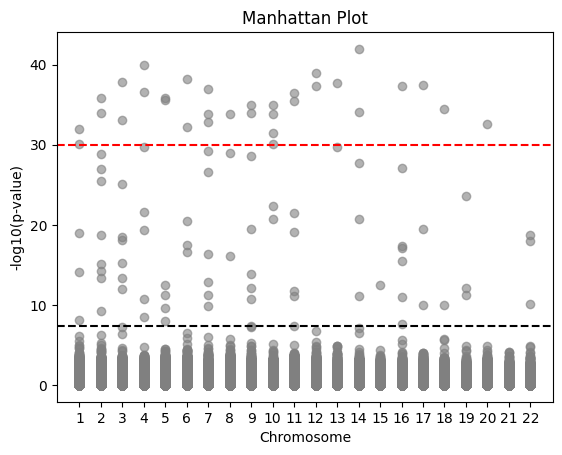

In [19]:
# Draw the Manhattan plot regarding to the chromosome and 
import matplotlib.pyplot as plt
ALL_RA_logP = pd.read_csv("Toy_example_expr/ALL_RA_logP.csv", sep="\t")
# ALL_RA_logP['scalePos'] = ALL_RA_logP['POS'].apply(lambda x: np.log10(x))
grouped_data = ALL_RA_logP.groupby('CHR')

fig, ax = plt.subplots()

x_ticks = []  # Stores the x-axis tick positions
x_labels = []  # Stores the x-axis tick labels
# for chromosome, group in grouped_data:
#     x = group['scalePos']
#     y = group['Neg_log10P']
    
#     ax.scatter(x, y, alpha=0.6, label = chromosome)
candidates_SNP = ['rs2281460','rs7785602','rs7259731','rs7012981','rs9559570','rs4811072','rs539959','rs2408366','rs4895986','rs4853363']
for i, (chromosome, group) in enumerate(grouped_data, start=1):
    x = [i] * len(group)  # Use the index i as the x-axis position for each chromosome
    y = group['Neg_log10P']
    # colors = ['red' if snp_id in ['rs4689152', 'rs11795051', 'rs9796234', 'rs11075875', 'rs2824310'] else 'gray' for snp_id in group['SNP']]
    
    
    ax.scatter(x, y, alpha=0.6, c = 'gray') # c=colors
    x_ticks.append(i)
    x_labels.append(chromosome)
    
ax.axhline(-np.log10(5e-8), color='black', linestyle='--', label='Significance Threshold')
ax.axhline(30, color='red', linestyle='--', label='Significance Threshold')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)  #, rotation=90
ax.set_xlabel('Chromosome')
ax.set_ylabel('-log10(p-value)')
ax.set_title('Manhattan Plot')
plt.show()


Use the <code>neg_log10(p-value)==30 </code> as threshold to find the names of the SNPs that are above this threshold (for which we consider as potential causal SNPs)

In [30]:
over_thre30 = ALL_RA_logP[ALL_RA_logP['Neg_log10P']>30]
print("number of rows:", len(over_thre30))
over_thre30

number of rows: 33


,CHR,SNP,POS,A1,A2,MAF,N,BETA,Z,SE,PVAL,Neg_log10P
77561,1,rs12404079,200507510,G,C,0.347658,1815,-0.270941,-11.542838,0.023473,8.023366e-31,30.095643
83996,1,rs17019491,212804965,C,G,0.392189,1818,-0.279338,-11.910428,0.023453,1.044397e-32,31.981134
131268,2,rs17568979,51031931,C,G,0.349451,1820,-0.287862,-12.280609,0.023440,1.151284e-34,33.938818
169974,2,rs10497012,148319727,T,A,0.341322,1815,-0.296228,-12.620151,0.023473,1.635084e-36,35.786460
217556,3,rs2268494,8802046,T,A,0.346854,1812,-0.284627,-12.115891,0.023492,8.701333e-34,33.060414
266976,3,rs11711999,122321909,T,A,0.340110,1820,-0.304310,-12.982295,0.023440,1.541903e-38,37.811943
304517,4,rs12647883,9878464,G,C,0.343644,1762,-0.318321,-13.361884,0.023823,1.009759e-40,39.995782
357993,4,rs12639667,140243822,C,G,0.356357,1817,-0.299492,-12.766221,0.023460,2.531509e-37,36.596620
395150,5,rs1021767,28234906,T,A,0.343218,1821,-0.296112,-12.636027,0.023434,1.336371e-36,35.874073
436949,5,rs3805610,127487719,G,C,0.359495,1822,-0.294644,-12.576842,0.023427,2.831242e-36,35.548023


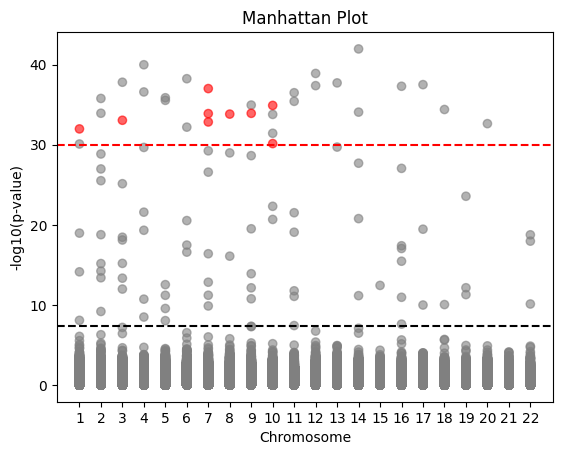

In [36]:
# Draw the Manhattan plot regarding to the chromosome and 
import matplotlib.pyplot as plt

ALL_RA_logP = pd.read_csv("Toy_example_expr/ALL_RA_logP.csv", sep="\t")
# ALL_RA_logP['scalePos'] = ALL_RA_logP['POS'].apply(lambda x: np.log10(x))
grouped_data = ALL_RA_logP.groupby('CHR')

fig, ax = plt.subplots()

x_ticks = []  # Stores the x-axis tick positions
x_labels = []  # Stores the x-axis tick labels
# for chromosome, group in grouped_data:
#     x = group['scalePos']
#     y = group['Neg_log10P']
    
#     ax.scatter(x, y, alpha=0.6, label = chromosome)

# found from upper threshold and google scholar.
candidates_SNP = ['rs17019491','rs2268494','rs1448657', 'rs1499614', 'rs2070677', 'rs17141741', 'rs4149327', 
                  'rs4149256', 'rs8192856']
for i, (chromosome, group) in enumerate(grouped_data, start=1):
    x = [i] * len(group)  # Use the index i as the x-axis position for each chromosome
    y = group['Neg_log10P']
    colors = ['red' if snp_id in candidates_SNP else 'gray' for snp_id in group['SNP']]
    
    
    ax.scatter(x, y, alpha=0.6, c=colors) #c = 'gray'
    x_ticks.append(i)
    x_labels.append(chromosome)
    
ax.axhline(-np.log10(5e-8), color='black', linestyle='--', label='Significance Threshold')
ax.axhline(30, color='red', linestyle='--', label='Significance Threshold')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)  #, rotation=90
ax.set_xlabel('Chromosome')
ax.set_ylabel('-log10(p-value)')
ax.set_title('Manhattan Plot')
plt.show()


<h3> Extract 100 SNPs, from ALL_chr22 </h3> to form new binary files.  
Random select 100 SNPs from ALL_chr22 and use the <code> "CMAll_qced/chr22/ALL_CM_chr22" </code> to get the binary files. 

1. cd "~/RA_Project/CMAll_qced/chr22"
2. run:  
<code> plink --bfile ALL_CM_chr22 --extract ../shuffle_100_ALL22.txt --make-bed --out shuffle_100snps </code>  
 

In [2]:
import pandas as pd
ALL_chr22_bim = pd.read_csv("CMAll_qced/ALL_chr22_bim.txt", sep="\t", header=None)
ALL_chr22_bim

,0
0,AFFX-SNP_10317090__rs135477
1,AFFX-SNP_10783944__rs7287369
2,AFFX-SNP_11178366__rs738961
3,AFFX-SNP_11498895__rs6519378
4,AFFX-SNP_11920032__rs2073327
...,...
18287,rs999223
18288,rs999224
18289,rs999458
18290,rs999540


In [5]:
# randomly select 100 SNPs from the "CMAll_qced/chr22/ALL_CM_chr22.bed" 
shuffle_100 = ALL_chr22_bim.sample(n=100, random_state=2)
shuffle_100
shuffle_100.to_csv("CMAll_qced/shuffle_100_ALL22.txt", sep="\t", index=False, header=None)

<h3> Correcting for Covariates </h3>
 (deltaDAS ~ SNP j + 10 PCs + sex + age + DAS) to generate marginal sumstat for each SNP j

Store <code> 2706 patient IDs </code> into "CMAll_qced/patientIID.csv"

In [8]:
#simulate 
g_sim = mgp.GWASimulator("CMAll_qced/chr22/ALL_CM_chr22",
                         pi = [.99, .01],
                         h2=0.5)
g_sim.simulate()
a= g_sim.to_phenotype_table().drop(["FID", "phenotype"], axis=1)
a.to_csv("CMAll_qced/patientIID.csv", index=False, sep="\t")

> Reading BED file...
> Generating polygenic scores...


In [9]:
pd.read_csv("CMAll_qced/patientIID.csv", sep="\t")

,IID
0,1000
1,2000
2,3000
3,4000
4,5000
...,...
2701,3061000
2702,3062000
2703,3064000
2704,3065000


From <code> DosageData </code> to get the genotpye data matrix(dosage) to put into <code> PCA </code>. from "data/DREAM_RA_Responders_DosageData"

In [21]:
dos_chr22 = pd.read_csv("data/DREAM_RA_Responders_DosageData/Training_chr22.dos", sep=" ", header=None)
dos_chr22 = dos_chr22.drop([0,2,3,4,5], axis=1).T
dos_chr22.columns = dos_chr22.iloc[0]
dos_chr22 = dos_chr22[1:]
dos_chr22.to_csv("data/Dosage_for_PCA/dos_chr22.csv", sep="\t", index=False)

In [23]:
dos_chr22 = pd.read_csv("data/Dosage_for_PCA/dos_chr22.csv", sep="\t")

In [24]:
dos_chr22

,rs915674,rs915677,rs9604721,rs4389403,rs9617528,rs1964966,rs12053774,rs7292653,rs1143974,rs2259866,...,rs8137951,rs2301584,rs756638,rs4824147,rs3810648,rs2285395,rs8136603,rs3888396,rs2238837,rs9616985
0,0.27,0.13,1.93,0.21,0.52,1.72,0.3,0.4,0.30,1.92,...,0.0,0.07,0.000000,2.0,2.0,0.0,1.98,0.19,1.73,0.07
1,0.27,0.13,1.93,0.21,0.52,1.72,0.3,0.4,0.33,1.97,...,1.0,0.12,0.000000,2.0,2.0,0.0,1.98,0.27,0.92,0.77
2,0.27,0.13,1.93,0.21,0.52,1.72,0.3,0.4,0.36,1.96,...,0.0,0.17,0.000000,2.0,2.0,0.0,1.98,0.20,1.50,0.08
3,0.27,0.13,1.93,0.21,0.52,1.72,0.3,0.4,0.36,1.95,...,1.0,0.60,0.000000,2.0,2.0,0.0,1.98,0.46,1.55,0.12
4,0.27,0.13,1.93,0.21,0.52,1.72,0.3,0.4,0.35,1.96,...,0.0,0.07,0.532012,1.5,2.0,0.0,1.98,0.08,1.36,0.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2701,0.27,0.13,1.93,0.21,0.52,1.72,0.3,0.4,0.29,1.94,...,0.0,0.08,0.000000,2.0,2.0,0.0,1.98,0.25,1.09,0.08
2702,0.27,0.13,1.93,0.21,0.52,1.72,0.3,0.4,0.35,1.96,...,0.0,0.06,0.000000,2.0,2.0,0.0,1.98,0.06,1.03,0.07
2703,0.27,0.13,1.93,0.21,0.52,1.72,0.3,0.4,0.40,1.93,...,0.0,0.06,0.000000,2.0,2.0,0.0,1.98,0.06,1.04,0.06
2704,0.27,0.13,1.93,0.21,0.52,1.72,0.3,0.4,0.46,1.97,...,0.0,0.92,0.000000,2.0,2.0,0.0,1.98,0.10,1.05,0.06


In [38]:
pca = PCA(n_components=10)
pcs = pca.fit_transform(dos_chr22)

In [39]:
pcs.shape

(2706, 10)

In [40]:
# Access the PC scores and explained variance ratio
pc_scores = pd.DataFrame(data=pcs, columns=[f"PC{i+1}" for i in range(pcs.shape[1])])
pc_scores
# explained_variance_ratio = pca.explained_variance_ratio_

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-9.778584,-4.343656,6.289703,1.986434,5.009737,9.753487,9.334282,-3.123055,2.808696,4.784271
1,5.039761,-4.987631,0.950794,-4.347200,0.651550,-14.483529,-9.373604,1.905750,-8.839978,1.360334
2,-8.573371,-1.901107,-9.921667,-3.100369,0.359638,-7.591280,-1.329375,-3.468643,5.062648,-0.873857
3,0.511762,2.422203,-12.495614,6.506481,-4.297431,-3.817247,12.283732,6.037878,2.107032,4.777219
4,-0.987192,-6.839897,1.505595,-3.719719,21.377274,2.212156,-12.391928,-4.788877,-6.772021,-4.340371
...,...,...,...,...,...,...,...,...,...,...
2701,-4.936222,2.235204,-12.937160,-1.818105,-4.220427,13.034949,-7.218082,-1.223867,-0.506971,-3.552101
2702,19.283713,6.410196,0.169506,10.189441,1.876041,3.897685,0.309023,-1.276261,-5.515444,-2.379267
2703,-6.486128,19.072578,1.688247,3.594879,-4.419686,-8.266317,6.438451,-12.447552,8.715413,0.731007
2704,7.810256,-4.956453,-1.308141,-0.743561,7.148363,10.902387,8.402288,-2.579034,-1.279271,-2.582707


Create <code> covariates_file </code>, which contains FID, IID, 10PCs + sex + age + baselineDAS
store in folder "data/Dosage_for_PCA"   July 9th
10PCs got from the dosage of chr22 above. 

In [46]:
DREAM_covaraites = pd.read_csv("data/DREAM_RA_Responders_PhenoCov_Full.txt", sep=" ")
DREAM_covaraites.insert(0, "FID", 0)
DREAM_covaraites = DREAM_covaraites.rename(columns={"ID":"IID"})
DREAM_covaraites = DREAM_covaraites[["FID","IID", "baselineDAS", "Age", "Gender"]]
DREAM_covaraites = pd.concat([DREAM_covaraites, pc_scores], axis=1)
DREAM_covaraites.to_csv("data/Dosage_for_PCA/chr22_covariates.csv", sep='\t', index=False, header=True)
DREAM_covaraites

,FID,IID,baselineDAS,Age,Gender,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,0,1877000,3.18,54.02000,0.0,-9.778584,-4.343656,6.289703,1.986434,5.009737,9.753487,9.334282,-3.123055,2.808696,4.784271
1,0,612000,4.65,61.08333,1.0,5.039761,-4.987631,0.950794,-4.347200,0.651550,-14.483529,-9.373604,1.905750,-8.839978,1.360334
2,0,111000,4.38,58.00000,1.0,-8.573371,-1.901107,-9.921667,-3.100369,0.359638,-7.591280,-1.329375,-3.468643,5.062648,-0.873857
3,0,1780000,2.45,51.07000,1.0,0.511762,2.422203,-12.495614,6.506481,-4.297431,-3.817247,12.283732,6.037878,2.107032,4.777219
4,0,825000,3.87,73.00000,1.0,-0.987192,-6.839897,1.505595,-3.719719,21.377274,2.212156,-12.391928,-4.788877,-6.772021,-4.340371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2701,0,2732000,5.19,NaN,1.0,-4.936222,2.235204,-12.937160,-1.818105,-4.220427,13.034949,-7.218082,-1.223867,-0.506971,-3.552101
2702,0,2736000,6.59,NaN,1.0,19.283713,6.410196,0.169506,10.189441,1.876041,3.897685,0.309023,-1.276261,-5.515444,-2.379267
2703,0,2744000,6.74,NaN,1.0,-6.486128,19.072578,1.688247,3.594879,-4.419686,-8.266317,6.438451,-12.447552,8.715413,0.731007
2704,0,2748000,5.01,NaN,1.0,7.810256,-4.956453,-1.308141,-0.743561,7.148363,10.902387,8.402288,-2.579034,-1.279271,-2.582707


<h5> Extract shuffled 500 SNPs from chr22</h5>
Similar with steps as <code> June 27th, shuffled 100 SNPs </code>   

1. cd "~/RA_Project/CMAll_qced/chr22"  
2. run:   
<code> plink --bfile ALL_CM_chr22 --extract ../shuffle_500_ALL22.txt --make-bed --out shuffle_500snps </code> 

In [2]:
ALL_chr22_bim = pd.read_csv("CMAll_qced/ALL_chr22_bim.txt", sep="\t", header=None)
ALL_chr22_bim
# randomly select 500 SNPs from the "CMAll_qced/chr22/ALL_CM_chr22.bed" 
shuffle_100 = ALL_chr22_bim.sample(n=500, random_state=2)
shuffle_100
shuffle_100.to_csv("CMAll_qced/shuffle_500_ALL22.txt", sep="\t", index=False, header=None)
